# A Horserace of Asset Allocations

Imagine you were sitting on the board of some large investor and you would like to decide on an approach for your strategic asset allocation. The following strategies might cross your mind: 

* **Mean-Variance Approach**: 
    * Idea: You maximize the Sharpe-Ratio of your portfolio by assuming mean returns, volatilities and correlations will stay roughly the same over the long run picking the portfolio which would have had the highest Sharpe-Ratio in the past.
    * Pro: Theorically sound to the extend that we believe in past performance, volatilities and covariances. 
    * Con: You have to estimate the above-mentioned variables, and assume them to remain stable.  
* **Minimum-Variance Approach**:
    * Idea: You minimize the volatlity of your portfolio by assuming volatilities and correlations will stay roughly the same over the long run.
    * Pro: Less volatility of the above and theoretically efficient as efficient as the portfolio with the highest Sharpe-Ratio if there is no risk-free rate and you cannot borrow. Additional benefit: you do not need to estimate mean returns. 
    * Con: You have to estimate two of the above-mentioned variables.
* **Risk-Parity**: 
    * Idea: You assume that certain assets come with different risk factors, which you would like to be exposed to equally, so that you do not take bets on the development of those risk factors. You keep the risk exposure of your portfolio in *parity* by weighting the assets according to the inverse of their variance ($1/Var(R_i)$)
    * Pro: You are - according to the theory - *truely diversified* because you believe the underlying risk-factors are uncorrelated.  
    * Con: You have to assume risk factors are different for each asset and uncorrelated and still rely on assumptions about the variances. 
* **Equally-Weighted**:
    * Idea: You keep it simple and just allocate all assets to the same degree, thereby selling winners and buying losers on rebalancing.
    * Pro: Very simple and especially successful during times of high volatility without strong trends.
    * Con: If trends in markets persist over rebalancings and or volatility is low. The strategy will sell what works and buy what does not.  
* **Black-Litterman**: Ask the economist and systematically integrate his views: 
    * Idea: You use the *Black-Litterman Model* to integrate the forward looking return assumptions economist estimate and weight them with your degree of certainty about those views. 
    * Pro: You systematically implement your ideas about the future and you no longer have to rely on historic means returns. Indeed the BL-Model does not need mean returns at all. All it needs is historical covariances and a benchmark or market weightings.  
    * Con: The model is only useful if you have quantifiable views and degrees of certainties. 

(The idea of this table comes from [Andrew Ang's book on factor investing](https://www.amazon.de/Asset-Management-Systematic-Investing-Association-ebook/dp/B00KW69ORW))

Historically, you invested your money into a global portfolio which had a very simple and suposedly all-weather proof asset allocation, which will be our **benchmark** in this exercise. 
* 60% Equities, of which
    * 30% was invested into European Stock (EuroStoxx 50)
    * 30% was invested into US-Stock (S&P 500)
* 35% 10-year Treasuries
* 5% Gold


Luckily, because you are such a long term investor. You have exactly one year to decide what to do. And you decide to give all of these strategies a paper track record during the time. Whoever wins the *horserace* will get your money. 

<img src="Data/Horserace.jpg">


In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
from scipy.optimize import minimize

pd.options.display.float_format = "{:.2f}".format
plt.style.use("seaborn-whitegrid")
%matplotlib inline
quandl.ApiConfig.api_key = "Jq_aYr5vETsGDgmPVVsA"
warnings.simplefilter("ignore")

## Data Selection and Tyding

We stick with the four assets we defined in our benchmark and use futures data from Quandl as this is the most accessible and free data source. 

In [2]:
benchmark = [0.3, 0.3, 0.05, 0.35]
Euro_Stoxx50 = quandl.get("CHRIS/EUREX_FESX1")
E_minis500 = quandl.get("CHRIS/CME_ES2")
Gold = quandl.get("CHRIS/CME_GC3")
treasury10y = quandl.get("CHRIS/CME_TY1")
names = ["EuroStoxx50", "S&P500EMinis", "Gold", "Treasury10y"]
futures = pd.concat(
    [
        Euro_Stoxx50["Settle"],
        E_minis500["Settle"],
        Gold["Settle"],
        treasury10y["Settle"],
    ],
    axis=1,
)
futures.columns = names

Lets take a first look at he rawr data. 

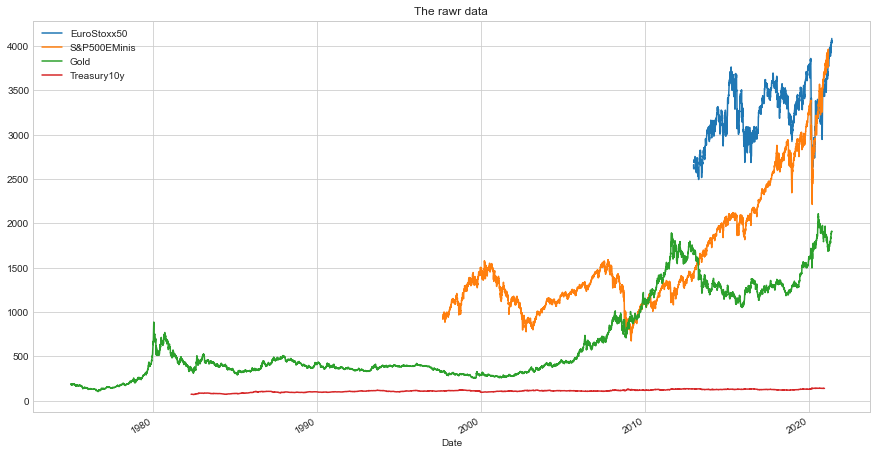

In [3]:
futures.plot(figsize=(15, 8), title="The rawr data");

It is fairly obvious, that we still need to do a little bit of data tyding. First of all, we will only consider time periods for which we have good data. According to the plot, the last series to start is the one on of the EuroStoxx 50, sometime around 2012. Secondly, we also need to index the data to that date, so that differences levels do not skew what we see. 

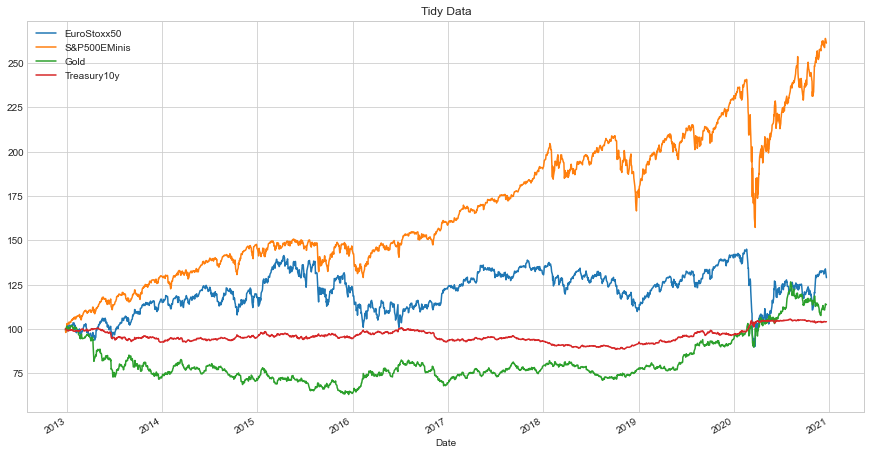

In [4]:
futures = futures.dropna()
futures = (futures/futures.iloc[0])*100
futures.plot(figsize=(15, 8), title="Tidy Data");

Looking at this data, we need to caveat that whilst the price return of the data will be decently accurate, the income we would get from investing into the underlying stocks and bonds is not considered.

Next we compute the data we will actually use in our analysis: 
* The annualized mean returns
* The annzalized variance-covariance-matrix

For convenience, we will take the log returns of the daily data and use that for the annualized mean returns ($average*252$) and our annualized (co-)variances ($variance*252$). We also only include data up until end of 2019, so that we do not optimize our portfolios with data from the time we want to test the portfolios.

In [5]:
futures_old = futures.loc[
    :"2019-12-31",
]
futures_old_log = np.log(futures_old / futures_old.shift(1)).dropna()
mean_returns = np.array((futures_old_log.mean() * 252))
var_covar = np.mat(futures_old_log.cov() * 252)
std_dev = np.diagonal(var_covar) ** 0.5

Let's look take a look at mean returns and variances: 

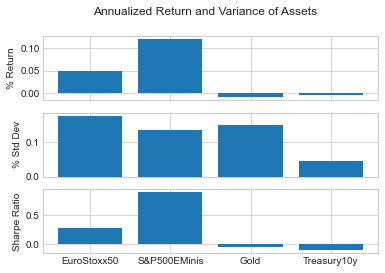

In [7]:
y_pos = range(0, len(mean_returns))
fig, axs = plt.subplots(3, sharex=True)
fig.suptitle('Annualized Return and Variance of Assets')
axs[0].bar(y_pos, mean_returns)
axs[0].label_outer()
axs[0].set(ylabel='% Return')
axs[1].bar(y_pos, std_dev)
axs[1].set(ylabel='% Std Dev')
axs[2].bar(y_pos, mean_returns/std_dev)
axs[2].set(ylabel='Sharpe Ratio')
plt.xticks(y_pos, names);

In [8]:
print("The precise Sharpe-Ratios are: ", mean_returns / std_dev, 2)

The precise Sharpe-Ratios are:  [ 0.27794717  0.90166159 -0.0570512  -0.10921821] 2


What's fairly striking to see is the sharpe ratio of the S&P 500 futures of approximately 0.9.

In [9]:
futures_old_log.corr()

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y
EuroStoxx50,1.00,0.57,-0.20,-0.33
S&P500EMinis,0.57,1.00,-0.08,-0.30
Gold,-0.20,-0.08,1.00,0.36
Treasury10y,-0.33,-0.30,0.36,1.00


The correlation matrix above also gives a good idea of how gold and treasury futures were able to diversify equity risks in the past. 

## Part I: Portfolio Construction

Let's finally construct the portfolios. Please see below for the approaches we are using: 
1. Mean-Variance approach: We pick the portfolio with the highest Sharpe-ratio in the past.
2. Minimum-Variance approach: We minimize the expression for the variance of the portfolio which is simply $weights^T*VarCovar*weights$
3. Risk-Parity: We scale the weights of the assets by the ivnerse of their variance. ($1/Var(R_i)$)
4. Equally Weighted: $1/N$
5. Black-Litterman Model: We set a reasonable, neutral benchmark for our portfolio to derive forward looking return estimates and give equally plausible views which we then weight by their certainty to form a weighted average for estimating returns.

To calculate all of these portfolios, we will need a couple of helper functions. Below, we include functions to compute the annualized variance and the annualized return of our Portfolios. Additionally, we make a function to create random weights in the interval [0,1] (no shorting, no borrowing), which we then use in our next function which iterates through $n$ portfolio combinations and calculates the portfolio variance and return with the functions above. Finally, we also use scipys optimizer to construct a minimum variance portfolio. To do so, we construct a function that takes the variance-covariance-matrix above as given and calculates the variane from weights that it uses as inputs. Finally, we constrain the optimized portfolio to sum up to 100% with the last function. 

In [10]:
# Portfolio Characteristics
def port_var(weights, var_mat):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    weights = np.mat(weights).T  # This is a usual vector with n rows and 1 column
    varcovar = np.mat(var_mat)  # This is a n*n matrix
    port_var = weights.T * varcovar * weights  # This will return a scalar
    return np.asscalar(port_var)


def port_ret(weights, returns):
    """
    Takes weights vector and mean returns to compute portfolio returns.
    """
    port_ret = np.asscalar(np.mat(returns) * np.mat(weights).T)
    return port_ret


# Efficient Frontier Calculation
def random_weights(k):
    """
    This function creates n number of weights that add up to 1
    """
    randoms = np.array(random.sample(population=range(0, 100), k=k))
    random_w = randoms / sum(randoms)
    return np.array(random_w)


def efficient_frontier(n, var_mat, returns):
    """
    This function will take the random_weights function and the port_var
    function, a variance covariance matrix and the mean returns of our
    assets to return a dataframe with weights,portfolio std dev,
    returns and sharpe ratio
    """
    efficient_frontier = np.empty([n, 7])
    for i in range(n):
        efficient_frontier[i, 0:4] = random_weights(4)
        efficient_frontier[i, 4] = (
            port_var(efficient_frontier[i, 0:4], var_covar) ** 0.5
        )
        efficient_frontier[i, 5] = port_ret(efficient_frontier[i, 0:4], mean_returns)
        efficient_frontier[i, 6] = efficient_frontier[i, 5] / efficient_frontier[i, 4]

    efficient_frontier = pd.DataFrame(
        efficient_frontier,
        columns=[
            "EuroStoxx50",
            "S&P500EMinis",
            "Gold",
            "Treasury10y",
            "Port_Std",
            "Port_Ret",
            "Sharpe",
        ],
        index=range(1, n + 1),
    )
    efficient_frontier = efficient_frontier.sort_values(by="Sharpe")

    return efficient_frontier


# Optimization Function and Constraints:


def min_var(weights):
    min_var = port_var(weights, var_covar)
    return min_var


def check_sum(weights):
    """
    Returns 0 if sum of weights is 1.0
    """
    return np.sum(weights) - 1

### 1. Mean-Variance Approach

Whilst we could find the portfolio with the highest Sharpe-ratio by using an optimizer, I think it is more interesting to use the opportunity and plot the entire efficient frontier that results from our assets. We will then pick the best of these portfolios, which, depending on how many iterations we run, should be very similar to the outcome of our optimization. 

How do we do this?

1. Create dozens of random portfolios of the four assets
2. Calculate their risk and returns
3. Plot it.

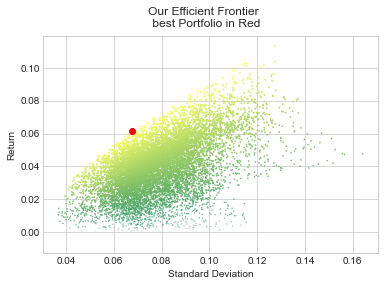

In [11]:
#Random portfolio weights: 
random.seed(1994)
n = 10000
efficient_frontier_df = efficient_frontier(n = n, var_mat = var_covar, returns = mean_returns)

#efficient_frontier_df
text = round(efficient_frontier_df["Sharpe"].max(),2)
fig, ax = plt.subplots()
fig.suptitle('Our Efficient Frontier \n best Portfolio in Red')
ax.scatter(
    x = efficient_frontier_df["Port_Std"],
    y = efficient_frontier_df["Port_Ret"],
    s = efficient_frontier_df["Sharpe"],
    c = efficient_frontier_df["Sharpe"],
    cmap = plt.cm.get_cmap("summer"))
ax.scatter(
    x = efficient_frontier_df["Port_Std"].tail(1),
    y = efficient_frontier_df["Port_Ret"].tail(1),
    c = "red");
ax.set(ylabel='Return')
ax.set(xlabel='Standard Deviation');

This figure shows 10,000 different portfolios,the brighter the color the better the sharpe ratio. The big red dot is the portfolio with the best sharpe ratio. We list it's precise properties below:

Mean-Variance (max. Sharpe-Ratio) Portfolio:
Annual Standard Deviation 0.07
Annual Return 0.06
Sharpe-Ratio 0.91


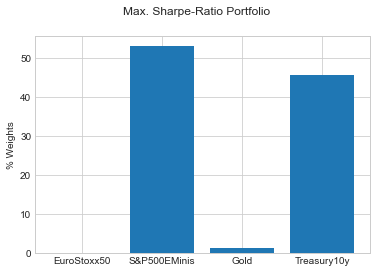

In [12]:
max_sr_weights = np.squeeze(np.array(efficient_frontier_df.tail(1).iloc[:,0:4]))
std_dev_max_sr = (port_var(max_sr_weights,var_covar))**0.5
return_max_sr = port_ret(max_sr_weights,mean_returns)
sharpe_max_sr = return_max_sr/std_dev_max_sr

print("Mean-Variance (max. Sharpe-Ratio) Portfolio:")
print("Annual Standard Deviation",round(std_dev_max_sr,2))
print("Annual Return",round(return_max_sr,2))
print("Sharpe-Ratio",round(sharpe_max_sr,2))

y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(1,sharex=True)
fig.suptitle('Max. Sharpe-Ratio Portfolio')
axs.bar(y_pos, max_sr_weights*100)
axs.set(ylabel='% Weights')
plt.xticks(y_pos, names);

### 2. Minimum-Variance Approach

Next, we compute our minimum-variance portfolio. We do so by minimizing the expresssion for our portfolio variance by optimizing our weights. We constrain our portfolio not to go short and we also do not allow borrowing. Our weights are hence all defined to be in the interval [0,1].

Minimum-Variance Portfolio:
Annual Standard Deviation 0.04
Annual Return 0.01
Sharpe-Ratio 0.4


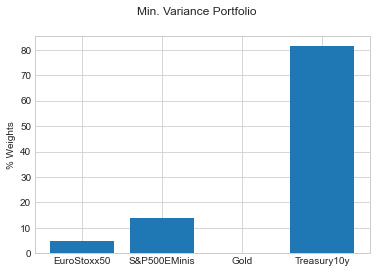

In [13]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight: No shortselling!
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
equal_weighted = [0.25,0.25,0.25,0.25]

min_var_weights = minimize(min_var,equal_weighted,method='SLSQP',bounds=bounds,constraints=cons).x
std_dev_min_var = (port_var(min_var_weights,var_covar))**0.5
return_min_var = port_ret(min_var_weights,mean_returns)
sharpe_min_var = return_min_var/std_dev_min_var

print("Minimum-Variance Portfolio:")
print("Annual Standard Deviation",round(std_dev_min_var,2))
print("Annual Return",round(return_min_var,2))
print("Sharpe-Ratio",round(sharpe_min_var,2))

y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(1,sharex=True)
fig.suptitle('Min. Variance Portfolio')
axs.bar(y_pos, min_var_weights*100)
axs.set(ylabel='% Weights')
plt.xticks(y_pos, names);

### 3. 1/N-Portfolio 

Since $1/4=0.25$, this is what we weight each asset with.

1/N Portfolio:
Annual Standard Deviation 0.07
Annual Return 0.04
Sharpe-Ratio 0.55


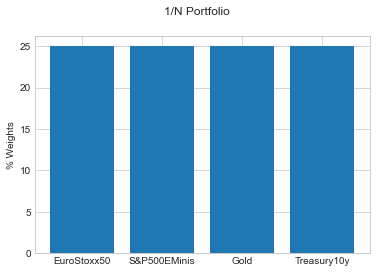

In [14]:
#Start with the equal weighted portfolio:
std_dev_equal = port_var(equal_weighted,var_covar)**0.5
return_equal = port_ret(equal_weighted,mean_returns)
sharpe_equal = return_equal/std_dev_equal

print("1/N Portfolio:")
print("Annual Standard Deviation",round(std_dev_equal,2))
print("Annual Return",round(return_equal,2))
print("Sharpe-Ratio",round(sharpe_equal,2))

y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(1,sharex=True)
fig.suptitle('1/N Portfolio')
axs.bar(y_pos, np.array(equal_weighted)*100)
axs.set(ylabel='% Weights')
plt.xticks(y_pos, names);

### 4. Risk-Parity Approach

To calculate our risk-parity portfolio, we weight the portfolio by the inverse of their variances by calcualting $(1/Variance_i)/sum(1/Variance_i)$. As we see below, this portfolio is actually exactly what people expect when talking about risk parity. Almost 80% of the portfolio is in treasuries, the rest is fairly evenly distributed. 

Risk-Parity Portfolio:
Annual Standard Deviation 0.04
Annual Return 0.01
Sharpe-Ratio 0.23


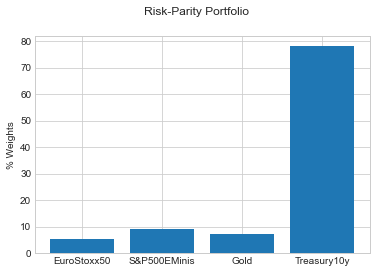

In [15]:
#Risk-Parity Portfolio:
riskp_weights = (1/std_dev**2)/sum(1/std_dev**2)
std_dev_riskp = port_var(riskp_weights,var_covar)**0.5
return_riskp = port_ret(riskp_weights,mean_returns)
sharpe_riskp = return_riskp/std_dev_riskp

print("Risk-Parity Portfolio:")
print("Annual Standard Deviation",round(std_dev_riskp,2))
print("Annual Return",round(return_riskp,2))
print("Sharpe-Ratio",round(sharpe_riskp,2))

y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(1,sharex=True)
fig.suptitle('Risk-Parity Portfolio')
axs.bar(y_pos, riskp_weights*100)
axs.set(ylabel='% Weights')
plt.xticks(y_pos, names);

### 5. The Black-Litterman Model 

This brings us to our last approach for asset allocations: the **Black-Litterman Model** (BL-model), which we implement by relying on [Ernst & Schurers book on portfolio management](https://www.amazon.de/Portfolio-Management-Theorie-Praxis-Matlab/dp/3825285626). Essentially, Black and Litterman adressed the fundamental problem of the mean-variance model which is its reliance on static return, variance and covariance estimations. The main issue with these estimates is of course, that they are not stable and therefore keeping them stable results in models which are backward looking in nature. Moreover, running a mean-variance optimization on the same assets for different time periods usually results in wieldly different outcomes, leading to lots of turnover and sometimes very narrowly concentrated portfolios. 

The BL-model adresses these issues by changing the methodology with which we forecast returns. BL-Returns are not generated by estimating historical means, but instead they are forward looking, by blending the unique views of portfolio managers with the current views of the market. The latter of which are calculated by reverse-engineering the mean-variance approach.


**Step by Step:**

1. In the first step the BL-model assumes that current market capizalizations reflect a mean-variance efficient portfolio conforming to modern portfolio theory, which in turn, means that by reversing the optimization, one can generate equilibrium implied returns for the assets. By plugging in the weightings (market caps/sum of market caps, in our case simply our benchmark) into the utility function and optimizing it, the returns that would generate these weightings if markets were in equilibrium are found.[1] Given that market capitalizations are strictly positive, the reference portfolio based on market capitalization is already more robust than a portfolio based on returns. In our example, this step results in a 'implied_returns' vector and a 'implied_weights' vector, the latter of which is identical to our benchmark. This is unsurprising given that the implied_weights vector is derived by doing the reverse optimization backward.

2. In a second step, the model allows investors to include their unique views, by expressing them in a vector. These views are then mapped to the implied returns of the securities by a mapping matrix, that can accomodate three types of views:

    * Absolute view: "A will return X% next year."
    * Relative view: "B will outperform C by X% next year."
    * Relative view: "A market cap weighted portfolio of stocks A, B, and C will outperform a market cap weighted portfolio of D and E by X% next year."

3. Portfoliomanagers can scale the uncertainty of all of the views by increasing a scalar tau or manipulate their uncertainty concerning specific views by manipulating a matrix that litteraly and symbolicly sits between the mapping matrix and the view vector. In our example, we follow Ernst and Schurer in computing the uncertainty of each view as a function of tau and the historical variance of the security in question.

4. Finally, the output of the Black-Litterman model is a vector of returns that is a weighted average between the implied portfolio returns as discussed above and the views of the portfoliomanager scaled by her general and stock-specific uncertainty. These robust and PM-unique return estimations are then used to optimize the portfolio. We use the scipy optimizer here again to be able to constrain our portfolio as we did before.

The Black-Litterman returns are called BL_returns, the thereby implied optimal portfolio is called BL_weights

[1] Given that the utility function of the investor includes the investors unique risk aversion ($delta$, which we assume to be 1), which does not drop out when calculating the derivative, one only derives the relative returns of the assets to each other, not the absolute returns.

In [16]:
def bl_neg_sr(weights):
    """
    Takes weights vector and Var-Covar Matrix to compute variance. 
    """
    sr = port_ret(weights, np.squeeze(BL_returns)) / port_var(weights, var_covar)
    return sr * -1

The views we use are just gut feelings for now and absolute in their nature: 
* EuroStoxx50 Futures: Europe faces structural problems, Brexit, is export oriented and therefore is hurt by the tradewar. We expect 5% return. 
* S&P 500 Futures: The US remains dynamic and benefits from the QE4. The US-Consumer is in great shape and will drive the economy. However, 2019 returns will not come back. We expect 10% return. 
* Gold: Gold has had a great run amidst ultra low real rates. However, given the trade war should be inflationary, real rates could even go lower. We expect 5% return.
* Treasuries: Nominal yields will not go much lower. We expect 2% return.

In [17]:
# The scalars:
##(Scalars assigend as in Ernst, Schurer)
delta = 1
tau = 0.2

# Vectors and Matrices
##Benchmark Weights

weights = np.array(benchmark)

##Mean Returns
mean_returns_T = np.mat(
    mean_returns
).T  # We shape our mean returns into a vector with which we can work

##View Vector
views = np.mat([0.05, 0.1, 0.05, 0.02]).T  # This is Q in  Ernst, Schurer

## Mapping Matrix
# 1 Row per view, 1 Column per Stock
P = np.mat(
    [
        [1, 0, 0, 0],  # Explanation: We expect EuroStoxx50 to have a return of 5%
        [0, 1, 0, 0],  # Explanation: We expect S&P500 to have a return of 10%
        [0, 0, 1, 0],  # Explanation: We expect Gold to have a return of 5%
        [0, 0, 0, 1],
    ]
)  # Explanation: We expect Treasuries to have a return of 2%

In [19]:
# Calculations

##Find Implied stock returns by reverse optimization (Ernst, Schurer p.505)
implied_returns = np.mat(
    delta * var_covar @ weights
).T  # called Psi in Ernst, Schurer pp.540 f.

##Calculate Omega
omega = np.diag(
    np.diag(P * tau @ var_covar @ P.T)
)  # Our certainty with which we formulate our views are based on the variances of the assets. The diagonal of the var-covar matrix.

##Reference_portfolios based on implied and historic returns
reference_portfolio_implied = (
    np.linalg.inv(delta * var_covar) @ implied_returns
)  # p.540
reference_portfolio_historic = (
    np.linalg.inv(delta * var_covar) @ mean_returns_T
)  # * #p.540

first_bracket = np.linalg.inv(
    np.linalg.inv(tau * var_covar)
    + P.T  # FIRST BRACKET: tau*var_covar inverted +
    @ np.linalg.inv(omega)
    @ P  # P'*Q*P
)

second_bracket = (
    np.linalg.inv(tau * var_covar)
    @ implied_returns  # SECOND BRACKET: tau*var_covar inverted *implied returns
    + P.T @ np.linalg.inv(omega) @ views  # P'*Q*Views
)

BL_returns = first_bracket @ second_bracket

BL_weights = minimize(
    bl_neg_sr, equal_weighted, method="SLSQP", bounds=bounds, constraints=cons
).x

BL_stds = (
    np.linalg.inv(tau * var_covar) + P.T * np.linalg.inv(omega) @ views  # P'*Q*Views
)

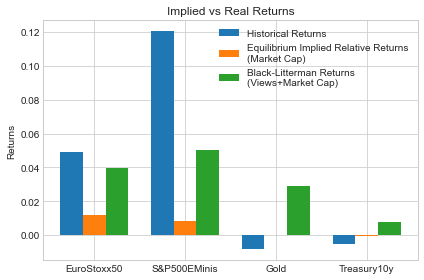

In [20]:
# create plot test
n_groups = 4
implied = sum(implied_returns.tolist(), [])
mean = sum(mean_returns_T.tolist(), [])
bl_returns = sum(BL_returns.tolist(), [])


fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25

rects1 = plt.bar(index, mean, bar_width, label="Historical Returns")

rects2 = plt.bar(
    index + bar_width,
    implied,
    bar_width,
    label="Equilibrium Implied Relative Returns\n(Market Cap)",
)

rects3 = plt.bar(
    index + bar_width * 2,
    bl_returns,
    bar_width,
    label="Black-Litterman Returns\n(Views+Market Cap)",
)

plt.ylabel("Returns")
plt.title("Implied vs Real Returns")
plt.xticks(index + bar_width, ("EuroStoxx50", "S&P500EMinis", "Gold", "Treasury10y"))
plt.legend()

plt.tight_layout()
plt.show()

Risk-Parity Portfolio:
Annual Standard Deviation 0.04
Annual Return 0.02
Sharpe-Ratio 0.23


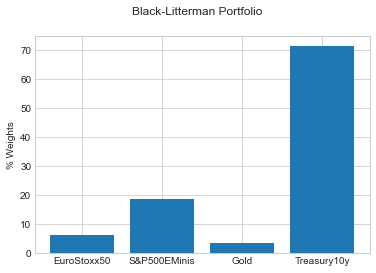

In [21]:
#Historical Data for current Black-Litterman Portfolio:
std_dev_bl = port_var(BL_weights,var_covar)**0.5
return_bl = port_ret(BL_weights,mean_returns)
sharpe_bl = return_riskp/std_dev_riskp

print("Risk-Parity Portfolio:")
print("Annual Standard Deviation",round(std_dev_bl,2))
print("Annual Return",round(return_bl,2))
print("Sharpe-Ratio",round(sharpe_bl,2))

y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(1,sharex=True)
fig.suptitle('Black-Litterman Portfolio')
axs.bar(y_pos, BL_weights*100)
axs.set(ylabel='% Weights')
plt.xticks(y_pos, names);

Note that in the above data, we took a forward looking estimate to construct our Black-Litterman Portfolio but estimated its Sharpe-ratio with historical return data. Hence, it's Sharpe-Ratio is not relevant to us.  

Lets collect all our data in a single Table to see how they fared in the past: 

In [22]:
port_data = np.mat(
    [
        [max_sr_weights, std_dev_max_sr, return_max_sr, sharpe_max_sr],
        [min_var_weights, std_dev_min_var, return_min_var, sharpe_min_var],
        [equal_weighted, std_dev_equal, return_equal, sharpe_equal],
        [riskp_weights, std_dev_riskp, return_riskp, sharpe_riskp],
        [BL_weights, std_dev_bl, return_bl, sharpe_bl],
    ]
)
port_indexes = ["MaxSR", "MinVar", "Equal", "RiskParity", "BlackLitterman"]
port_df = pd.DataFrame(
    port_data, columns=["Weights", "Port_Std", "Port_Ret", "Sharpe"], index=port_indexes
)
df2 = pd.DataFrame(
    port_df["Weights"].values.tolist(), columns=names, index=port_indexes
)
port_df = pd.merge(df2, port_df, left_index=True, right_index=True).drop(
    "Weights", axis=1
)
del df2

port_df

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y,Port_Std,Port_Ret,Sharpe
MaxSR,0.00,0.53,0.01,0.46,0.07,0.06,0.91
MinVar,0.05,0.14,0.00,0.81,0.04,0.01,0.4
Equal,0.25,0.25,0.25,0.25,0.07,0.04,0.55
RiskParity,0.05,0.09,0.07,0.78,0.04,0.01,0.23
BlackLitterman,0.06,0.19,0.04,0.71,0.04,0.02,0.23


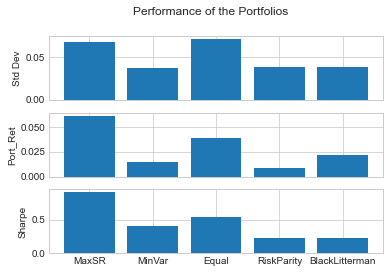

In [23]:
y_pos1 = range(0,len(port_df.index))
fig, axs = plt.subplots(3,sharex=True)
fig.suptitle('Performance of the Portfolios')
axs[0].bar(y_pos1, port_df["Port_Std"])
axs[0].label_outer()
axs[0].set(ylabel='Std Dev')
axs[1].bar(y_pos1, port_df["Port_Ret"])
axs[1].set(ylabel='Port_Ret')
axs[2].bar(y_pos1, port_df["Sharpe"])
axs[2].set(ylabel='Sharpe')

plt.xticks(y_pos1, port_df.index);

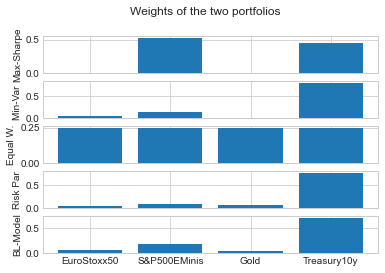

In [24]:
random_max_sr_weights = efficient_frontier_df.loc[efficient_frontier_df["Sharpe"].idxmax()][0:4]
y_pos = range(0,len(mean_returns))
fig, axs = plt.subplots(5,sharex=True)
fig.suptitle('Weights of the two portfolios')
axs[0].bar(y_pos, max_sr_weights)
axs[0].label_outer()
axs[0].set(ylabel='Max-Sharpe')
axs[1].bar(y_pos, min_var_weights)
axs[1].set(ylabel="Min-Var  ")
axs[2].bar(y_pos, equal_weighted)
axs[2].set(ylabel="Equal W.")
axs[3].bar(y_pos, riskp_weights)
axs[3].set(ylabel="Risk Par")
axs[4].bar(y_pos, BL_weights)
axs[4].set(ylabel='BL-Model')

plt.xticks(y_pos, names);

## Conclusions from historic data: 

Looking at the above plots the characteristics of each of the portfolios becomes evident: 

* Mean Variance approach: To no ones surprise our mean-variance portfolios is the best one since we have chosen the ideal weights **ex-post**. 
* Minimum Variance: Our minimum variance portfolio is basically just treasuries and has indeed the lowest variance. Again no surprise here.
* Risk-Parity: A risk parity portfolio is also heavily invested into treasuries, which is exactly how risk parity is often used in practise. It was also superior to our min var portfolio, but fared worse than the equal weighted portfolio.
* Equally Weighted: Our $1/N$ portfolio fared relatively well during the time. However, its large allocation to european stocks which did absolutely nothing in terms of generating return or diversifying the portfolio was probably not idea. 
* Black-Litterman: Our current Black-Litterman portfolio looks relatively similiar to the risk-parity portfolio, being havily invested into treasuries and a little into the S&P 500.

In conclusion, for the last five years, a simple 60-40 portfolio of S&P500 and treasuries with some 1% of gold would have been a great portfolio. But how would those portfolios have done since the beginning of the year?

## Part II: The Horse Race

Finally, after constructing the portfolios as described above, lets test them against each other. We will rebalance them quaterly. 

In [25]:
# Take current data
futures_new = futures.loc[
    "2019-12-31":,
]
futures_new = futures_new.dropna()
days_since_start = len(futures_new.index)
futures_new_log = np.log(futures_new / futures_new.shift(1)).dropna()
mean_returns_n = np.array((futures_new_log.mean() * 252))
var_covar_n = np.mat(futures_new_log.cov() * 252)
std_dev_n = np.diagonal(var_covar_n) ** 0.5

Let's first take a look at how markets are developing:

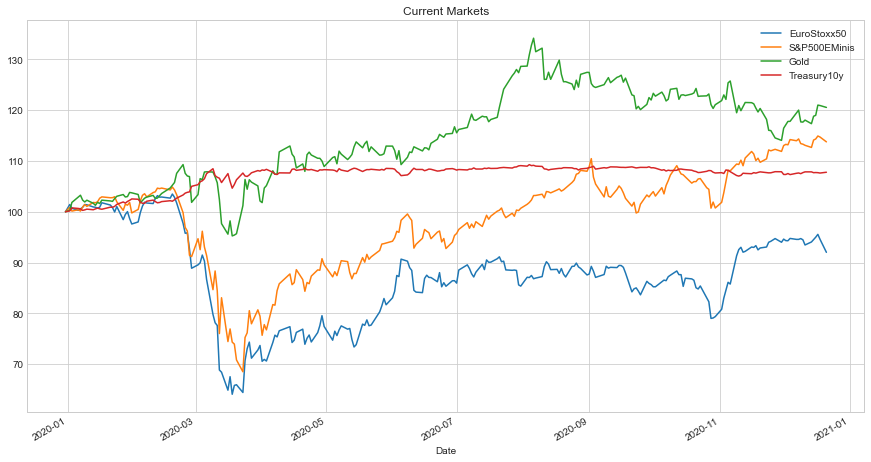

In [26]:
futures_index = (futures_new/futures_new.iloc[0])*100
futures_index.plot(figsize = (15,8), title="Current Markets");

And how do our portfolios plot against each other? See below for their realized performance:

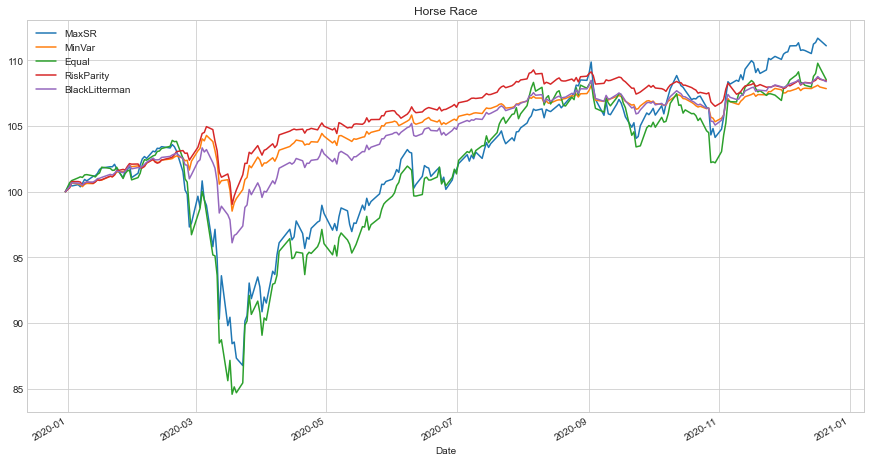

In [27]:
horse_race_df = pd.DataFrame(columns = port_df.index.tolist())

for method in port_df.index.tolist():
    horse_race_df[method] = (futures_index*port_df.loc[method][0:4]).sum(axis=1) #

horse_race_df.plot(figsize = (15,8),title="Horse Race");

In [28]:
horse_race_ports_df = port_df.copy(deep=True)
horse_race_ports_df = horse_race_ports_df.drop("Port_Std", axis=1)
horse_race_ports_df = horse_race_ports_df.drop("Port_Ret", axis=1)


for method in port_df.index.tolist():
    horse_race_ports_df.at[method, "Annual_Vol"] = horse_race_df[:][
        method
    ].pct_change().std() * (252 ** 0.5)
    horse_race_ports_df.at[method, "Annual_Ret"] = (
        (float(horse_race_df[method].tail(1)) / 100) ** (252 / days_since_start)
    ) - 1
    horse_race_ports_df.at[method, "YTD_Ret"] = (
        float(horse_race_df[method].tail(1)) / 100
    ) - 1

horse_race_ports_df["Sharpe"] = (
    horse_race_ports_df["Annual_Ret"] / horse_race_ports_df["Annual_Vol"]
)
horse_race_ports_df

,EuroStoxx50,S&P500EMinis,Gold,Treasury10y,Sharpe,Annual_Vol,Annual_Ret,YTD_Ret
MaxSR,0.00,0.53,0.01,0.46,0.76,0.15,0.11,0.11
MinVar,0.05,0.14,0.00,0.81,1.70,0.05,0.08,0.08
Equal,0.25,0.25,0.25,0.25,0.58,0.15,0.09,0.09
RiskParity,0.05,0.09,0.07,0.78,1.79,0.05,0.09,0.08
BlackLitterman,0.06,0.19,0.04,0.71,1.40,0.06,0.09,0.08
